# Hits, misses and false alarms
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 30-11-2023<br>


**Introduction**:<br>
This notebooks computes the hits (true positives, $TP$), misses (false negatives, $FN$) and false alarms (false positives, $FP$) for all the selected reporting points and the complete study period.

The input data are the data sets of exceedance over threshold both for the reanalsysis ("observed") and the forecast.

The confusion matrix (hits, misses, false alarms) is computed for all the possible combinations of three criteria: model combination method (named _approach_), persistence, and probability threshold. The values of persisntece and probability thresholds for which the confusion matrix will be evaluated are defined by the user.

The result is a new set of NetCDF files (one for station) that contains matrixes of hits, misses and false alarms for every combination of the criteria.

**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)<br>
[Instructions for sending EFAS flood notifications](https://efascom.smhi.se/confluence/display/EDC/Instructions+for+sending%2C+upgrading+and+deactivating+EFAS+Flood+Notifications)

In [1]:
import os
path_root = os.getcwd()
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import yaml
import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from compute import *
from seasonal import disaggregate_by_season
from convert import reshape_DataArray, dict2da
from plot.results import plot_DataArray, plot_weights, plot_brier_skill
from plot.maps import create_cmap, map_events
os.chdir(path_root)

In [2]:
# Set the default text font size
plt.rc('font', size=15)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=15)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=13)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=13)
# Set the legend font size
plt.rc('legend', fontsize=13)
# Set the font size of the figure title
plt.rc('figure', titlesize=17)

## 1 Configuration

In [3]:
with open("../conf/config_COMB_all_leadtimes.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

### 1.1 Reporting points

In [4]:
# area threshold
area_threshold = cfg.get('reporting_points', {}).get('area', 500)

# fixed notification criteria for the optimization process
area_optimization = cfg.get('skill', {}).get('area', 2000) 

# reporting points
path_stations = cfg.get('reporting_points', {}).get('output', '../results/reporting_points/')
file_stations = f'{path_stations}reporting_points_over_{area_threshold}km2.parquet'

### 1.2 Exceedance

In [5]:
# return period
rp = cfg.get('discharge', {}).get('return_period', {}).get('threshold', 5)

# path where results from the preprocessing steps were saved
path_reanalysis = cfg.get('exceedance', {}).get('output', {}).get('reanalysis', f'../results/exceedance/reanalysis/') + f'{rp}/'
path_forecast = cfg.get('exceedance', {}).get('output', {}).get('forecast', f'../results/exceedance/forecast/') + f'{rp}/'

### 1.1 Hits

#### Notification criteria

##### Probability threshold

In [6]:
# probability thresholds
probability_range = cfg.get('hits', {}).get('criteria', {}).get('probability', [.05, .096, .05])
probability = np.arange(*probability_range).round(3)
probability = xr.DataArray(probability, dims=['probability'], coords={'probability': probability})

##### Persistence

A list of tuples with two values: the first value is the width of the window rolling sum, and the second value the minimum number of positives in that window so that a notification is raised.

In [7]:
persistence = cfg.get('hits', {}).get('criteria', {}).get('persistence', [(1, 1), (2, 2), (2, 3)])
persistence = {'/'.join([str(i) for i in pers]): pers for pers in persistence}

##### Computation of hits

In [8]:
# lead time ranges
leadtime = cfg.get('hits', {}).get('leadtime', None)

# parameters of the rolling window used to compute hits
window = cfg.get('hits', {}).get('window', 1)
center = cfg.get('hits', {}).get('center', True)

# dissagregate the analysis by seasons?
seasonality = cfg.get('hits', {}).get('seasonality', False)

# path where the dataset of hits, misses and false alarms will be saved
path_out_root = cfg.get('hits', {}).get('output', f'../results/hits/')
path_weights = f'{path_out_root}/combination/weighing/'
if leadtime is None:
    folder = 'all_leadtimes'
elif len(leadtime) == 10:
    folder = 'daily'
elif len(leadtime) == 20:
    folder = '12h'
else:
    folder = '_'.join([str(lt + 12) for lt in leadtime])
path_out = f'{path_out_root}combination/{folder}/'
if seasonality:
    path_out += 'seasonal/'
for path in [path_out_root, path_weights, path_out]:
    if not os.path.exists(path):
        os.makedirs(path)

## 2 Data

### 2.1 Reporting points

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [9]:
# load table of fixed reporing points
stations = pd.read_parquet(file_stations)

### 2.2 Exceedance reanalysis

In [10]:
# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = xr.open_mfdataset(f'{path_reanalysis}*.nc', combine='nested', concat_dim='id')['exceedance']
rean_exc = rean_exc.sel(id=stations.index).compute()

if seasonality:
    rean_exc = disaggregate_by_season(rean_exc)

print(rean_exc.dims)
print(rean_exc.shape)

('id', 'datetime')
(2371, 3919)


### 2.3 Exceedance forecast

In [11]:
# load probability of exceeding the discharge threshold in the FORECAST data
fore_exc = xr.open_mfdataset(f'{path_forecast}*.nc', combine='nested', concat_dim='id')
fore_exc['id'] = fore_exc.id.astype(int)
fore_exc = fore_exc.sel(id=stations.index)

# reshape the DataArray of forecasted exceedance
fore_exc = xr.Dataset({label: reshape_DataArray(da, trim=True) for label, da in fore_exc.items()})
fore_exc = fore_exc.transpose('id', 'datetime', 'leadtime', 'model')

# extract starting and ending dates
if ('start' not in locals()) or ('end' not in locals()):
    start = pd.to_datetime(max(rean_exc.datetime.min().data, fore_exc.datetime.min().data))
    end = pd.to_datetime(min(rean_exc.datetime.max().data, fore_exc.datetime.max().data))
else:
    start = max(start, rean_exc.datetime.min(), fore_exc.datetime.min())
    end = min(end, rean_exc.datetime.max(), fore_exc.datetime.max())

# recalculate the exceedance datasets to convert the 3 classes (>Q5, >0.95·Q5, <0.95·Q5) to only 2 (exceedance, non-exceedance)
rean_exc, fore_exc = recompute_exceedance(rean_exc.sel(datetime=slice(start, end)),
                                          fore_exc['high'].sel(datetime=slice(start, end)),
                                          fore_exc['low'].sel(datetime=slice(start, end)))

### 2.3 Weighting factors

**Brier weighting**

In [12]:
# COMPUTE BRIER SCORE
brier = {}
for model in fore_exc.model.data:
    # extract model forecast
    pred =  fore_exc.sel(model=model).dropna('leadtime', how='any').transpose()
    # squared error
    se = (pred - rean_exc)**2
    # Brier score
    brier[model] = se.mean(['id', 'datetime'])

# convert dictionary to DatArray
brier = dict2da(brier, dim='model')

# CONVERT BRIER SCORE INTO WEIGHTING FACTORS
# e = 1e-5
# weights_brier = (brier.max() + e - brier) / (brier.max() + e - (brier.min() - e))
w = 7
weights_brier = brier**-w
weights_brier /= weights_brier.sum('model')

# export
weights_brier.to_netcdf(f'{path_weights}weights_brier_{rp}.nc')

In [15]:
# climatology
Pclim = 0
se= (Pclim - rean_exc)**2
brier_clim = se.mean(['id', 'datetime'])

# Brier skill score
BSS = (brier_clim - brier) / brier_clim

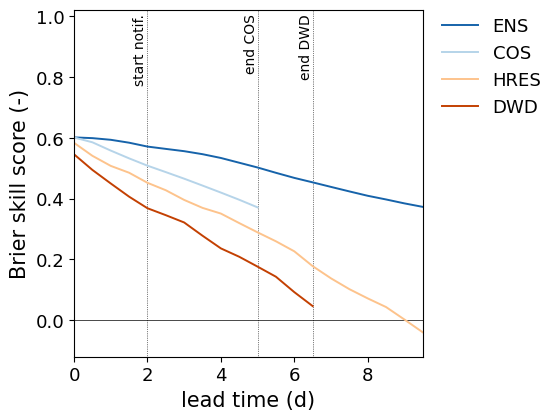

In [30]:
# create a copy of 'skill_opt' to change acronyms
ds = BSS.copy()
ds['model'] = ds['model'].where(ds['model'] != 'EUD', 'HRES')
ds['model'] = ds['model'].where(ds['model'] != 'EUE', 'ENS')
ds = ds.reindex(model=['ENS', 'COS', 'HRES', 'DWD'])

# plot the Brier skill score
top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((top(np.linspace(0.2, .95, 128)),
                       bottom(np.linspace(.05, .8, 128))))
BuOr = ListedColormap(newcolors, name='BlueOrange')

df = plot_brier_skill(ds,
                      cmap=BuOr,
                      ylim=(-.12, 1.02),
                      save=f'{path_weights}Brier_skill_score_{rp}.pdf')

>***Figure 1**. Brier skill score for every meteorological model and lead time. The benchmark is a model whose probability of exceedance is 0.*

**Member weighting**

In [32]:
# compute weights by number of members
weights_member = weights_brier.copy()
for model in models:
    weights_member.loc[{'model': model}] = weights_member.sel(model=model).where(weights_brier.sel(model=model).isnull(), models[model]['members'])
weights_member /= weights_member.sum('model')

# export
weights_member.to_netcdf(f'{path_weights}weights_member.nc')

**Model mean**

In [33]:
# compute weights by number of members
weights_mean = weights_brier.copy()
weights_mean = weights_mean.where(weights_mean.isnull(), other=1)
weights_mean /= weights_mean.sum('model')

# export
weights_mean.to_netcdf(f'{path_weights}weights_mean.nc')

**Compare weighing methods**

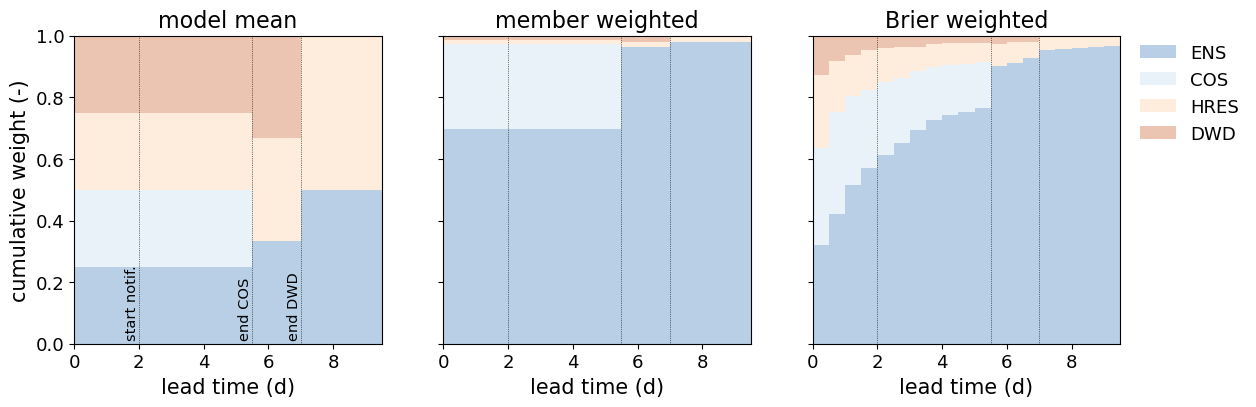

In [47]:
# heatmap of weights
Weights = xr.Dataset({'model mean': weights_mean, 'member weighted': weights_member, 'Brier weighted': weights_brier})
Weights['model'] = Weights['model'].where(Weights['model'] != 'EUD', 'HRES')
Weights['model'] = Weights['model'].where(Weights['model'] != 'EUE', 'ENS')
Weights = Weights.reindex(model=['ENS', 'COS', 'HRES', 'DWD'])

plot_weights(Weights,
             cmap=BuOr,
             offset=-12,
             save=f'{path_weights}weights.pdf')

>***Figure 2**. Weights assigned to each NWP model and lead time in the three total probability approaches.*

## 3 Analysis

### 3.1 Observed events
#### 3.1.1 Number of events

In [21]:
# find the onset of the events
onsets =  xr.concat((rean_exc.isel(datetime=0).astype(bool), rean_exc.diff('datetime')), dim='datetime') == 1
onsets = onsets.sel(datetime=slice(start, end))

# find the offset of the events
offsets = xr.concat((rean_exc.isel(datetime=0).astype(bool), rean_exc.diff('datetime')), dim='datetime') == -1
offsets = offsets.sel(datetime=slice(start, end))

# count number of events
stations['n_events_obs'] = onsets.sum('datetime').to_pandas()

print('No. stations with observed events:\t{0}'.format((stations.n_events_obs > 0).sum()))
print('No. observed events:\t\t\t{0}'.format(stations.n_events_obs.sum()))

if seasonality:
    # compute number of events per season
    rean_onsets4s = disaggregate_by_season(rean_onsets, dim='datetime')
    cols = ['n_events_obs_winter', 'n_events_obs_spring', 'n_events_obs_summer', 'n_events_obs_autumn']
    stations[cols] = rean_onsets4s.sum('datetime').to_pandas().transpose()

# export the stations table
stations.to_parquet(file_stations)

No. stations with observed events:	1159
No. observed events:			2082


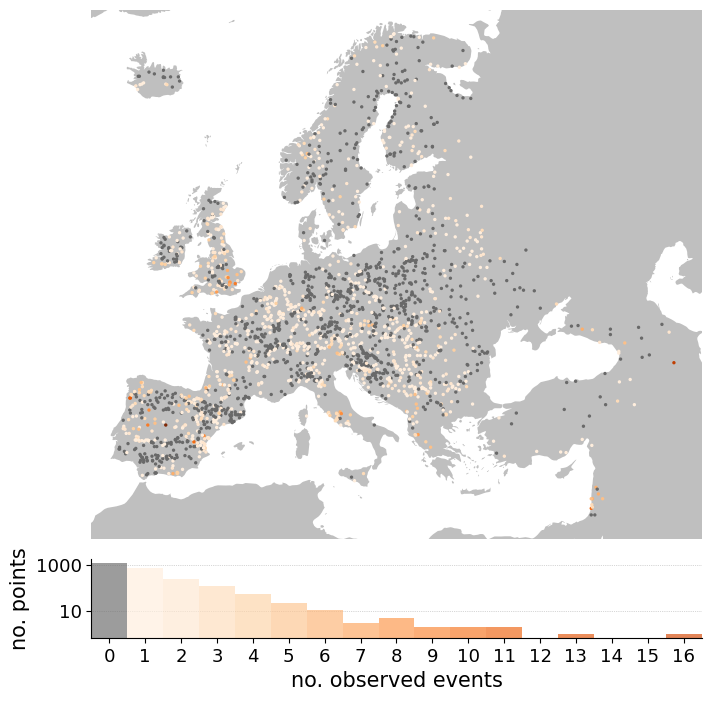

In [22]:
# map of the number of events
map_events(stations, 'n_events_obs', yscale='log', alpha=1, save=f'{path_out_root}/map_observed_events_{stations.shape[0]}points.pdf')

> ***Figure 3**. Number of observed flood events during the study period.*

The geographical distribution of events is not even. There is a higher proportion of stations with events in Central Europe, British Isles and the Mediterranean catchments than in Estearn and North-Eastern Europe. During the study period there were major events in the Rhine, Meuse and Ebro, which can be seen in the map.

The reporting points with more than 5 flood events during the study period were removed, since it is suspicious that the 5-year return period was exceeded so many times in only 2 years of study period.

#### 3.1.2 Duration of the events

In [23]:
# evaluate the duration (in hours) of each event
event_durations = {}
for stn in tqdm(onsets.id.data):
    if stations.loc[stn, 'n_events_obs'] == 0:
        continue
    # dates of the onsets and offsets of the events
    dates_onsets = onsets.sel(id=stn).where(onsets.sel(id=stn), drop=True).datetime.data
    dates_offsets = offsets.sel(id=stn).where(offsets.sel(id=stn), drop=True).datetime.data
    # corrections in case the amount of onsets and onsets don't match
    if len(dates_onsets) > len(dates_offsets):
        dates_offsets = np.append(dates_offsets, offsets.datetime[-1].data)
    elif len(dates_onsets) < len(dates_offsets):
        dates_onsets = np.append(onsets.datetime[0].data, dates_onsets)
    # correction in case the first onset is later that the first offset
    else:
        if dates_onsets[0] > dates_offsets[0]:
            print(stn)
            dates_onsets = np.append(onsets.datetime[0].data, dates_onsets)
            dates_offsets = np.append(dates_offsets, offsets.datetime[-1].data)
    # convert into hours
    durations = (dates_offsets - dates_onsets) / np.timedelta64(1, 'h')
    event_durations[stn] = durations

  0%|          | 0/2371 [00:00<?, ?it/s]

In [24]:
# convert dictionary of durations into a flattened array
durations_all, durations_opt = [], []
for stn, arr in event_durations.items():
    for d in arr:
        durations_all.append(d)
        if stations.loc[stn, 'area'] >= area_optimization:
            durations_opt.append(d)
durations_all = np.array(durations_all)
durations_opt = np.array(durations_opt)

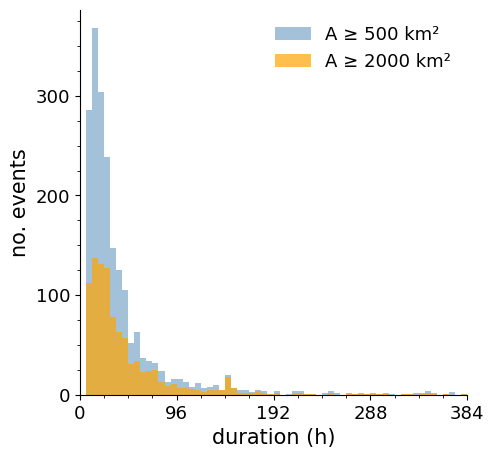

In [25]:
# plot distribution of event duration
alpha = .7
xmin = 0
xmax = 16 * 24
bins = np.arange(xmin, xmax + 1, 6).astype(int)

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(durations_all, ax=ax, alpha=alpha**2, bins=bins, color='steelblue', edgecolor=None, label=f'A ≥ {area_threshold} km²')
sns.histplot(durations_opt, ax=ax, alpha=alpha, bins=bins, color='orange', edgecolor=None, label=f'A ≥ {area_optimization} km²')
ax.set(xlabel='duration (h)', ylabel='no. events', xlim=(xmin, xmax));
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(96))
ax.xaxis.set_minor_locator(MultipleLocator(24))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.legend(frameon=False);

plt.savefig(f'{path_out_root}duration_distribution_{stations.shape[0]}points.pdf', dpi=300, bbox_inches='tight')

>***Figure 4**. Distributions of the duration of the observed flood events. In blue the events observed in points with a catchment area of at least 500 km², in orage those that exceed 2000 km².*

In [ ]:
# plot distribution of event duration
alpha = .7
xmin = 0
xmax = 16 * 24
bins = np.arange(xmin, xmax + 1, 6).astype(int)

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(durations_all, ax=ax, alpha=alpha**2, bins=bins, color='steelblue', edgecolor=None, label=f'A ≥ {area_threshold} km²')
sns.histplot(durations_opt, ax=ax, alpha=alpha, bins=bins, color='orange', edgecolor=None, label=f'A ≥ {area_optimization} km²')
ax.set(xlabel='duration (h)', ylabel='no. events', xlim=(xmin, xmax));
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(96))
ax.xaxis.set_minor_locator(MultipleLocator(24))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.legend(frameon=False);

#plt.savefig(f'{path_out_root}duration_distribution_{stations.shape[0]}points.pdf', dpi=300, bbox_inches='tight')

### 3.2 Hits, misses and false alarms

In [32]:
path_netcdf = f'{path_out}window_{window}/'
if os.path.exists(path_netcdf) is False:
    os.makedirs(path_netcdf)

for stn in tqdm(stations.index):

    # check if the output file already exists
    file_out = f'{path_netcdf}{stn:>04}.nc'
    if os.path.exists(file_out):
        continue
        
    # FORECAST EXCEEDANCE PROBABILITY
    forecast = fore_exc.sel(id=stn)

    # TOTAL PROBABILITY OF EXCEEDANCE

    # exceedance according to 1 deterministic + 1 probabilistic
    deterministic = (forecast.sel(model=['EUD', 'DWD']) >= probability).any('model')
    probabilistic = (forecast.sel(model=['EUE', 'COS']) >= probability).any('model')
    deterministic_probabilistic = deterministic & probabilistic

    # exceedance according to mean over models
    model_mean = forecast.mean('model', skipna=True) >= probability

    # exceedance according to the mean over models weighted by the number of members
    member_weighted = forecast.weighted(weights_member.fillna(0)).mean('model', skipna=True) >= probability

    # exceedance according to the mean over models weighted by the inverse Brier score
    brier_weighted = forecast.weighted(weights_brier.fillna(0)).mean('model', skipna=True) >= probability

    # merge all total probability approaches in a single DataArray
    total_exc = xr.Dataset({
                            '1_deterministic_+_1_probabilistic': deterministic_probabilistic,
                            'model_mean': model_mean,
                            'member_weighted': member_weighted,
                            'brier_weighted': brier_weighted,
                            }).to_array(dim='approach')

    del forecast

    # HITS, MISSES, FALSE ALARMS
    
    hits = {}
    for label, pers in persistence.items():

        # compute predicted events
        pred = exceedance2events(total_exc, persistence=pers, leadtime=leadtime)

        # disaggregate seasonaly
        if seasonality:
            pred = disaggregate_by_season(pred)

        # compute hits, misses and false alarms
        # if 'leadtime' in pred.dims:
        #     aux = events2hits(rean_exc.sel(id=stn), pred, center=center, w=window)
        # else:
        #     aux = events2hits(rean_exc, pred, center=center, w=window)
        hits[label] = events2hits(rean_exc.sel(id=stn), pred, center=center, w=window)
    hits = dict2da(hits, dim='persistence')

    print(f'Exporting file {file_out}', end='\r')
    hits.to_netcdf(file_out)

    del pred, hits

  0%|          | 0/2371 [00:00<?, ?it/s]